# Part 2

## Data Augumentation and CNN improvements:

## Loading libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import keras
from keras import backend as K
from tensorflow.keras.datasets import mnist
from __future__ import print_function
from tensorflow.keras.optimizers import RMSprop
from time import time
import numpy as np

Using TensorFlow backend.


## Uploading the fashion mnist dataset which was split into train and test data before hand

In [3]:
(trainX, trainy), (testX, testy) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


## Looking at the shape of the train and test data

In [4]:
print(trainX.shape)
print(trainy.shape)
print(testX.shape)
print(testy.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Assigning number of rows and columns to variables for further use


In [5]:
n_rows = trainX.shape[1]
n_cols = trainX.shape[2]

## Description of the labels

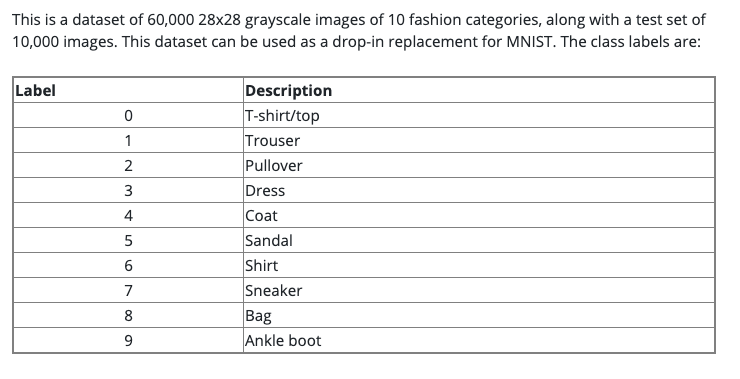

## Creating a dictionary which corresponds to the label and its name.

In [6]:
label_mapping = {0:"T-shirt/top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"}
num_classes = len(label_mapping)

## Defining a function which shifts the given image randomly by 9 units to the right, left, up or down.

In [7]:
def shift(image):
  shift = np.random.choice([-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9])
  ax = np.random.choice([0,1])
  image = np.roll(image,shift,axis = ax)
  if ax == 1:
    if shift < 0:
      image[:,shift:] = 0      
    else:
      image[:,:shift] = 0
  else:
    if shift < 0:
      image[shift:,:] = 0      
    else:
      image[:shift,:] = 0
  return image


## Testing the above function

([], <a list of 0 Text major ticklabel objects>)

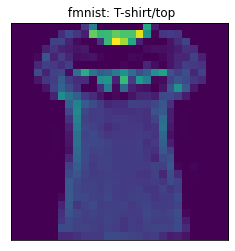

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
d = trainX[34]
plt.imshow(d )
plt.title(" fmnist: " + label_mapping[trainy[34]])
plt.xticks([])
plt.yticks([])



([], <a list of 0 Text major ticklabel objects>)

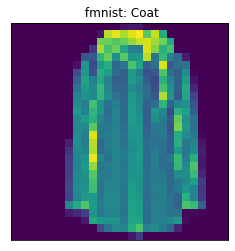

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
d = trainX[47281]
plt.imshow(shift(d) )
plt.title(" fmnist: " + label_mapping[trainy[47281]])
plt.xticks([])
plt.yticks([])

## Recreating data of size same as original data size, By passing each image into the above defined shift function to randomly shift each image by 9 units to the right, left, up or down.

In [10]:
x_shift = []
y_shift = []
for i in range(len(trainX)):
  x_shift.append(shift(trainX[i]))
  y_shift.append(trainy[i])

## Randomly testing the shifted image to check and tune the number of units the image is allowed to shift by.

([], <a list of 0 Text major ticklabel objects>)

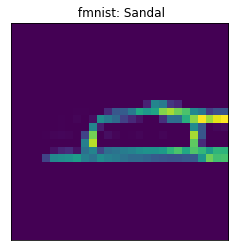

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
d = x_shift[3034]
plt.imshow(d )
plt.title(" fmnist: " + label_mapping[y_shift[3034]])
plt.xticks([])
plt.yticks([])



## Joining the shifted images to the original fmnist images

In [12]:
x_train = []
x_train.extend(trainX)
x_train.extend(x_shift)
x_train = np.asarray(x_train)

y_train = []
y_train.extend(trainy)
y_train.extend(y_shift)
y_train = np.asarray(y_train)

## Normalising and reshaping the dataset

In [13]:
x_train = x_train.reshape(x_train.shape[0], n_rows, n_cols, 1)
x_test = testX.reshape(testX.shape[0], n_rows, n_cols, 1)
input_shape = (n_rows, n_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (120000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
120000 train samples
10000 test samples


## Using Image Data Generator for rotation, random cropping(zoom), horizontal flip and vertical flip. This is data augumentation function is then fitted to the recently formed training data( of length 120000)

In [14]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=60, zoom_range = 0.1,
                             fill_mode = 'constant',cval = 0,horizontal_flip=True,vertical_flip=True)
datagen.fit(x_train)

## Each of the above training image is passing to the fucntion with batch size 1 to get the generated images which can be included into training data 

In [15]:
x_batch = []
y_batch = []
for a,b in datagen.flow(x_train,y_train,batch_size =1):
    x_batch.append(np.array(np.expand_dims(a.squeeze(),-1),dtype = 'float64'))
    y_batch.append(int(b))
    if len(x_batch)>=120000:
        break
    

In [16]:
len(y_batch)

120000

## Randomly checking the above generated images

([], <a list of 0 Text major ticklabel objects>)

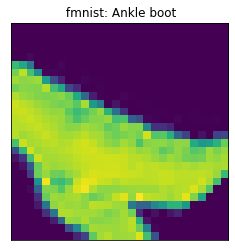

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
d = x_batch[9839][:,:,0]
plt.imshow(d )
plt.title(" fmnist: " + label_mapping[y_batch[9839]])
plt.xticks([])
plt.yticks([])



## A final training dataset of length 240000 is formed with the help above data augumentation techniques

In [18]:
final_x_train = []
final_x_train.extend(x_train)
final_x_train.extend(x_batch)
final_x_train = np.asarray(final_x_train)
print(final_x_train.shape)

final_y_train = []
final_y_train.extend(y_train)
final_y_train.extend(y_batch)
final_y_train = np.asarray(final_y_train)
final_y_train.shape

(240000, 28, 28, 1)


(240000,)

## One-hot Encoding

In [19]:
final_y_train = tf.keras.utils.to_categorical(final_y_train, num_classes)
testy = tf.keras.utils.to_categorical(testy, num_classes)

In [20]:
final_y_train.shape

(240000, 10)

# Applying Convolutional networks

## Applying the same ConvNet used in the part 1

In [31]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Dropout(0.2))

# model.add(Conv2D(128, kernel_size=(3,3),padding="valid", activation='relu'))
# deep_model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3,3),padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [32]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer = Adam(),
              # optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [34]:
batch_size = 64
epochs = 8

In [35]:

history = model.fit(final_x_train, final_y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, testy),shuffle=True,
                   callbacks=[reduce_lr])


Epoch 1/8
3750/3750 [==============================] - 73s 20ms/step - loss: 0.8150 - accuracy: 0.7010 - val_loss: 0.3197 - val_accuracy: 0.8868 - lr: 0.0010
Epoch 2/8
3750/3750 [==============================] - 73s 20ms/step - loss: 0.5609 - accuracy: 0.7962 - val_loss: 0.2559 - val_accuracy: 0.9121 - lr: 0.0010
Epoch 3/8
3750/3750 [==============================] - 74s 20ms/step - loss: 0.4872 - accuracy: 0.8229 - val_loss: 0.2402 - val_accuracy: 0.9140 - lr: 0.0010
Epoch 4/8
3750/3750 [==============================] - 73s 19ms/step - loss: 0.4392 - accuracy: 0.8406 - val_loss: 0.2285 - val_accuracy: 0.9177 - lr: 0.0010
Epoch 5/8
3750/3750 [==============================] - 73s 20ms/step - loss: 0.4058 - accuracy: 0.8509 - val_loss: 0.2290 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 6/8
3750/3750 [==============================] - 73s 19ms/step - loss: 0.3778 - accuracy: 0.8606 - val_loss: 0.2285 - val_accuracy: 0.9201 - lr: 0.0010
Epoch 7/8
3750/3750 [==============================]

In [36]:
score = model.evaluate(x_test, testy, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2312827855348587
Test accuracy: 0.9200000166893005


The Testing accuracy had crosses 92% after the 5th epoch and settled at exactly 92 % by the end of 8th epoch

---

## Confusion Matrix

In [37]:
from sklearn.metrics import confusion_matrix
import numpy as np

test_predictions = model.predict_classes(x_test)

cm = confusion_matrix(np.argmax(testy, axis=1), test_predictions)
print(cm)

[[908   1  14   8   4   2  60   0   2   1]
 [  3 986   0   5   2   0   2   0   2   0]
 [ 17   1 865   7  63   0  47   0   0   0]
 [ 19   5   6 882  56   0  31   0   1   0]
 [  1   1  17  11 943   0  25   0   2   0]
 [  0   0   0   0   0 985   0  14   1   0]
 [111   2  48  13 104   0 719   0   3   0]
 [  0   0   0   0   1   4   0 980   0  15]
 [  1   0   4   2   8   4   6   1 974   0]
 [  1   1   0   0   0   6   0  34   0 958]]


Text(0.5, 1.0, 'Accuracy Score: 0.9200000166893005')

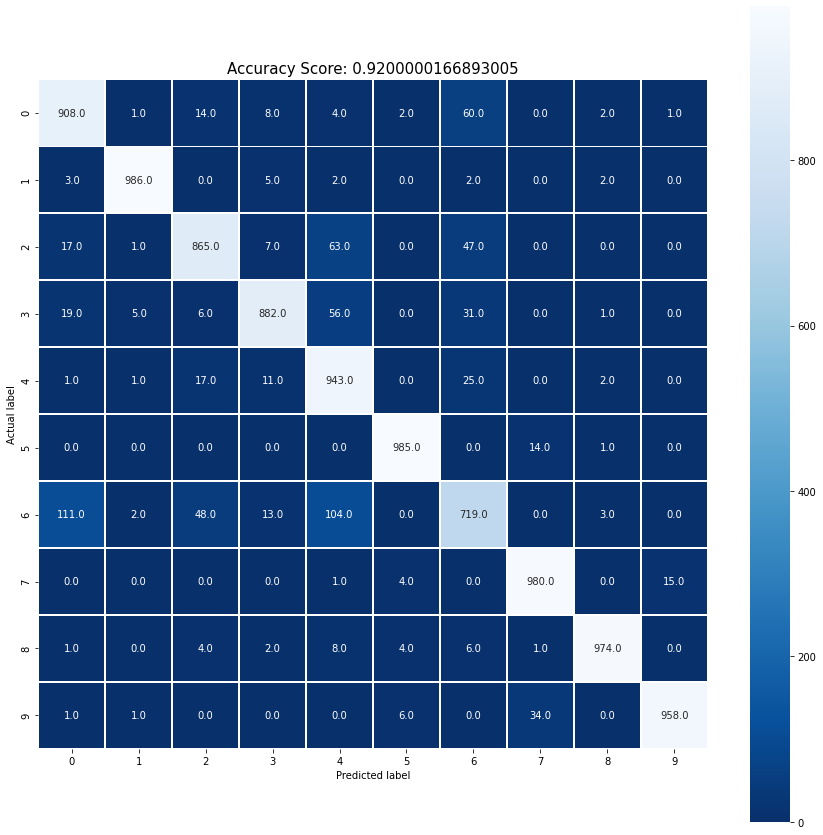

In [38]:
import seaborn as sns

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score[1])
plt.title(all_sample_title, size = 15)

## Plotting Test and Train Accuracies

## Train Vs Validation Accuracy


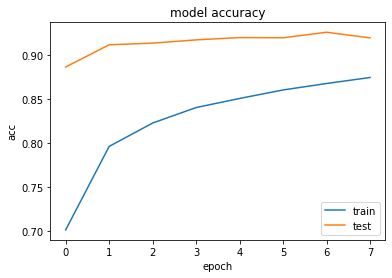

In [39]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Plotting model loss

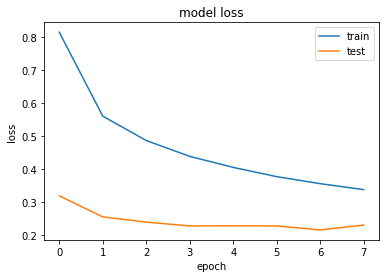

In [40]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Observations

The Testing accuracy had crosses 92% after the 5th epoch and settled at exactly 92% by the end of 8th epoch.  
In this ConvNet we have used Dropouts to put the effect of regularization, we can see that the network was still learning and trying to get good accuracies.  
And we can also observe that model had fit test accuracy more efficiently than training data.

----

## Applying ConvNet2 with increased epochs and batch size to let the model learn more.

In [21]:
model1 = Sequential()

model1.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))

model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(Dropout(0.2))

# model.add(Conv2D(128, kernel_size=(3,3),padding="valid", activation='relu'))
# deep_model.add(Dropout(0.2))

model1.add(Conv2D(128, kernel_size=(3,3),padding="same", activation='relu'))
model1.add(MaxPooling2D(pool_size=(3,3)))
model1.add(Dropout(0.2))

model1.add(Flatten())

model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(num_classes, activation='softmax'))

In [22]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)

model1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer = Adam(),
              # optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [23]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [24]:
batch_size = 128
epochs = 32


history1 = model1.fit(final_x_train, final_y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, testy),shuffle=True,
                   callbacks=[reduce_lr])


Epoch 1/32
1875/1875 [==============================] - 61s 32ms/step - loss: 0.8414 - accuracy: 0.6914 - val_loss: 0.3092 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 2/32
1875/1875 [==============================] - 61s 32ms/step - loss: 0.5776 - accuracy: 0.7903 - val_loss: 0.2564 - val_accuracy: 0.9078 - lr: 0.0010
Epoch 3/32
1875/1875 [==============================] - 61s 32ms/step - loss: 0.4968 - accuracy: 0.8197 - val_loss: 0.2329 - val_accuracy: 0.9168 - lr: 0.0010
Epoch 4/32
1875/1875 [==============================] - 61s 33ms/step - loss: 0.4502 - accuracy: 0.8360 - val_loss: 0.2382 - val_accuracy: 0.9163 - lr: 0.0010
Epoch 5/32
1875/1875 [==============================] - 61s 32ms/step - loss: 0.4161 - accuracy: 0.8468 - val_loss: 0.2275 - val_accuracy: 0.9197 - lr: 0.0010
Epoch 6/32
1875/1875 [==============================] - 61s 32ms/step - loss: 0.3888 - accuracy: 0.8578 - val_loss: 0.2211 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 7/32
1875/1875 [========================

In [25]:
score1 = model1.evaluate(x_test, testy, verbose=0)

print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 0.24903938174247742
Test accuracy: 0.9301999807357788


We can observe a decrease in the loss function and improved training accuracies. We also observe testing accuracy crossing 92% and reaching 93% by the end 32 epochs.

---


## Confusion Matrix

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Accuracy Score: 0.9301999807357788')

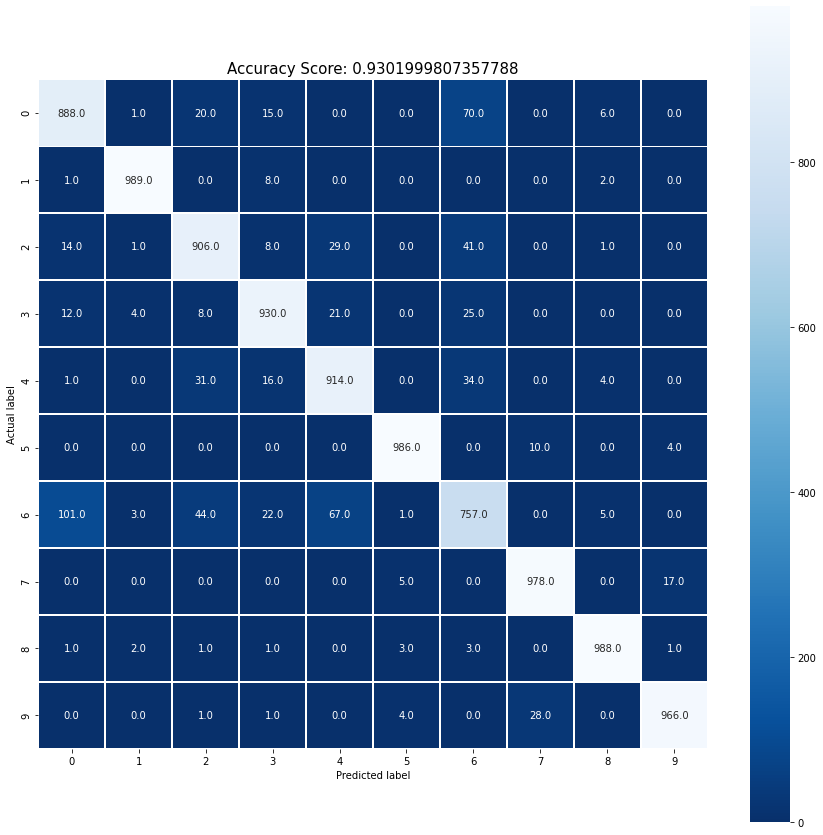

In [27]:
from sklearn.metrics import confusion_matrix
import numpy as np

test_predictions = model1.predict_classes(x_test)

cm = confusion_matrix(np.argmax(testy, axis=1), test_predictions)
# print(cm)

import seaborn as sns

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score1[1])
plt.title(all_sample_title, size = 15)

## Plotting Test and Train Accuracies
## Train Vs Validation Accuracy


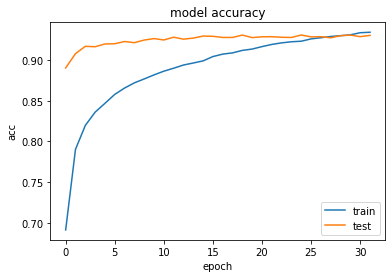

In [29]:
plt.figure()
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Plotting model loss

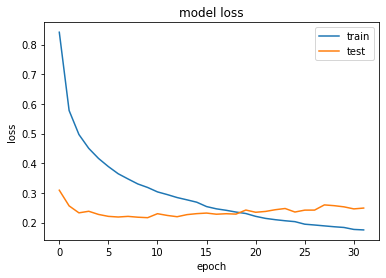

In [30]:
plt.figure()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Observations

We can observe a decrease in the loss function and improved training accuracies. We also observe testing accuracy crossing 92% and reaching 93% by the end 32 epochs.  
Apparently ReduceLROnPlateau had been affective after increasing the epochs and allowing the model to learn more. We can also observe that with the help of ReduceLROnPlateau, model reduced its learning rate as it neared the optimal solution.  
The increase of training accuracy was more significant and evident than the increase of the testing accuracy. By the end of final epoch, training accuracy had crossed 93% and looked like it may overfit if we train further.

-----

## Applying ConvNet3, by adding regularizers to convolutional layers for the previous convnet model

In [45]:
model2 = Sequential()

model2.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))

model2.add(Conv2D(64, (3,3), activation='relu',kernel_regularizer='l2'))# activity_regularizer = regularizers.l1_l2(0.005,0.005)))
model2.add(Dropout(0.2))

model2.add(Conv2D(64, (5,5), activation='relu'))
model2.add(Dropout(0.2))

model2.add(Conv2D(128, kernel_size=(3,3),padding="same", activation='relu', kernel_regularizer='l2'))
model2.add(MaxPooling2D(pool_size=(3,3)))
model2.add(Dropout(0.2))

model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(num_classes, activation='softmax'))

In [46]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)

model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer = Adam(),
              # optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [47]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout_9 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 64)        102464    
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)        

In [48]:
batch_size = 128
epochs = 32


history2 = model2.fit(final_x_train, final_y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, testy),shuffle=True,
                   callbacks=[reduce_lr])

Epoch 1/32
1875/1875 [==============================] - 73s 39ms/step - loss: 1.0745 - accuracy: 0.6402 - val_loss: 0.5327 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 2/32
1875/1875 [==============================] - 72s 39ms/step - loss: 0.8223 - accuracy: 0.7215 - val_loss: 0.4512 - val_accuracy: 0.8677 - lr: 0.0010
Epoch 3/32
1875/1875 [==============================] - 72s 38ms/step - loss: 0.7499 - accuracy: 0.7497 - val_loss: 0.4155 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 4/32
1875/1875 [==============================] - 72s 38ms/step - loss: 0.7085 - accuracy: 0.7670 - val_loss: 0.4208 - val_accuracy: 0.8727 - lr: 0.0010
Epoch 5/32
1875/1875 [==============================] - 72s 39ms/step - loss: 0.6773 - accuracy: 0.7800 - val_loss: 0.3989 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 6/32
1875/1875 [==============================] - 73s 39ms/step - loss: 0.6534 - accuracy: 0.7892 - val_loss: 0.3770 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 7/32
1875/1875 [========================

In [49]:
score2 = model2.evaluate(x_test, testy, verbose=0)

print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Test loss: 0.3272738456726074
Test accuracy: 0.9100000262260437


We can observe that adding regularisers has stopped training data from overfitting. But Testing accuracy can be seen settling at 91% which are a little lesser than previous convnet model

## Confusion Matrix

Text(0.5, 1.0, 'Accuracy Score: 0.9100000262260437')

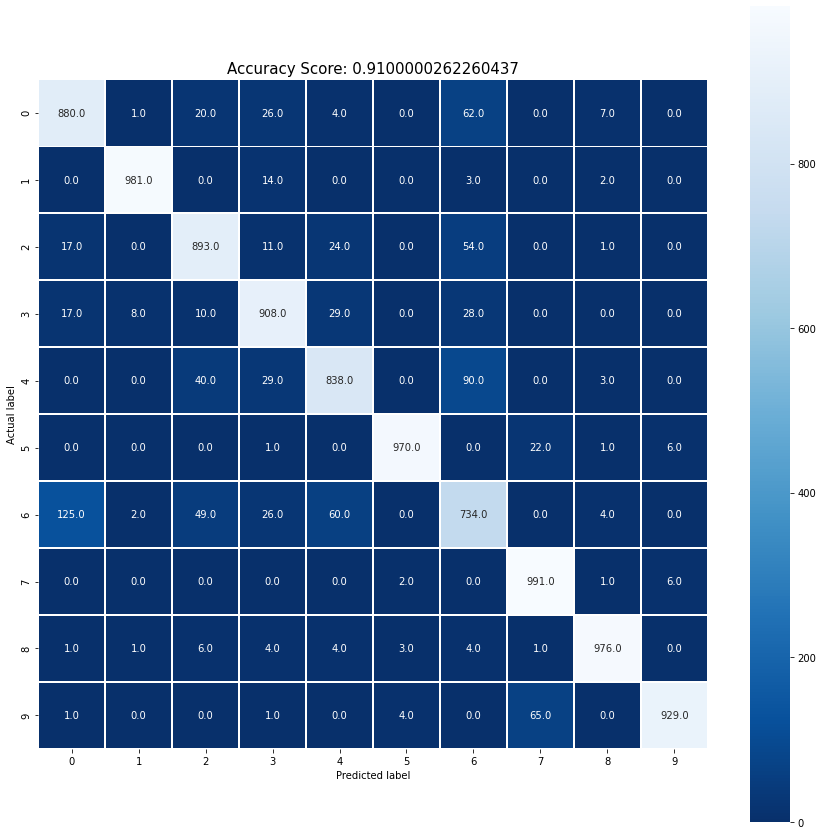

In [50]:
from sklearn.metrics import confusion_matrix
import numpy as np

test_predictions = model2.predict_classes(x_test)

cm = confusion_matrix(np.argmax(testy, axis=1), test_predictions)
# print(cm)

import seaborn as sns

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score2[1])
plt.title(all_sample_title, size = 15)

## Plotting Test and Train Accuracies
## Train Vs Validation Accuracy


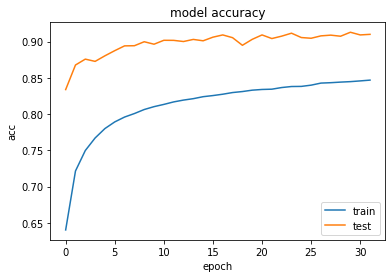

In [51]:
plt.figure()
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Plotting model loss

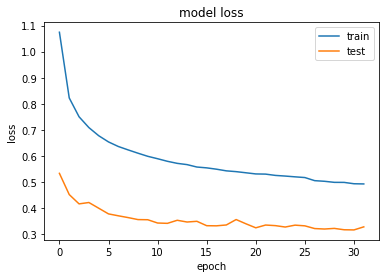

In [52]:
plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Observation:

We can observe that adding regularizers has stopped training data from overfitting. But Testing accuracy can be seen settling at 91% which are a little lesser than previous convnet model.  
And we can clearly see from the above model loss plot and the accuracies plot that the model got has stopped improving its training accuracy and reducing training loss as effectively as the previous models where regularization was not used.

## Applying ConvNet4, by adding early stopping to convolutional layers for the previous convnet model

In [53]:
model3 = Sequential()

model3.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))

model3.add(Conv2D(64, (3,3), activation='relu'))
model3.add(Dropout(0.2))

# model3.add(Conv2D(64, (5,5), activation='relu'))
# model3.add(Dropout(0.2))

model3.add(Conv2D(128, kernel_size=(5,5),padding="same", activation='relu'))
model3.add(MaxPooling2D(pool_size=(3,3)))
model3.add(Dropout(0.2))

model3.add(Flatten())

model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(num_classes, activation='softmax'))

In [54]:
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

model3.compile(loss=keras.losses.categorical_crossentropy,
              # optimizer = Adam(),
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [55]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)             

In [56]:
batch_size = 128
epochs = 32


history3 = model3.fit(final_x_train, final_y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, testy),shuffle=True,
                   callbacks=[callback])

Epoch 1/32
1875/1875 [==============================] - 67s 36ms/step - loss: 2.2011 - accuracy: 0.1973 - val_loss: 1.8894 - val_accuracy: 0.4731
Epoch 2/32
1875/1875 [==============================] - 66s 35ms/step - loss: 1.9590 - accuracy: 0.3018 - val_loss: 1.4537 - val_accuracy: 0.5949
Epoch 3/32
1875/1875 [==============================] - 66s 35ms/step - loss: 1.8461 - accuracy: 0.3358 - val_loss: 1.3141 - val_accuracy: 0.6173
Epoch 4/32
1875/1875 [==============================] - 66s 35ms/step - loss: 1.7877 - accuracy: 0.3535 - val_loss: 1.2314 - val_accuracy: 0.6355
Epoch 5/32
1875/1875 [==============================] - 66s 35ms/step - loss: 1.7384 - accuracy: 0.3687 - val_loss: 1.1669 - val_accuracy: 0.6483
Epoch 6/32
1875/1875 [==============================] - 66s 35ms/step - loss: 1.6958 - accuracy: 0.3833 - val_loss: 1.1057 - val_accuracy: 0.6653
Epoch 7/32
1875/1875 [==============================] - 66s 35ms/step - loss: 1.6543 - accuracy: 0.3973 - val_loss: 1.0507 -

In [57]:
score3 = model3.evaluate(x_test, testy, verbose=0)

print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

Test loss: 0.6620287895202637
Test accuracy: 0.7649999856948853


We can observe that early stopping defined to control the training loss to the default 'auto' mode, had made the model limit the reduction of the training loss, resulting in the lesser accuracies than the previous models.

Text(0.5, 1.0, 'Accuracy Score: 0.7649999856948853')

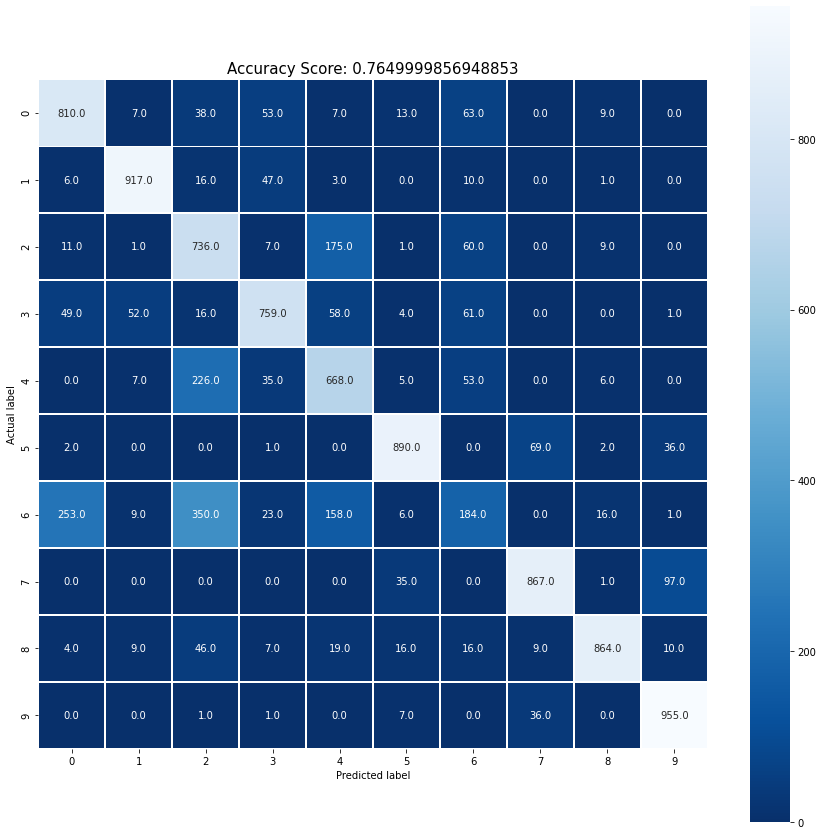

In [58]:
from sklearn.metrics import confusion_matrix
import numpy as np

test_predictions = model3.predict_classes(x_test)

cm = confusion_matrix(np.argmax(testy, axis=1), test_predictions)
# print(cm)

import seaborn as sns

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score3[1])
plt.title(all_sample_title, size = 15)

## Plotting Test and Train Accuracies.
## Train Vs Validation Accuracy


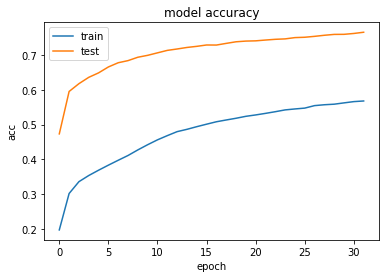

In [60]:
plt.figure()
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Plotting model Loss

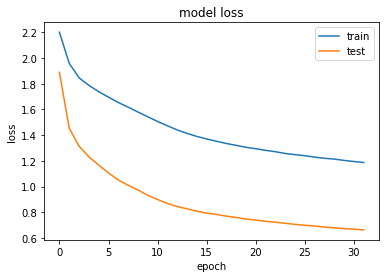

In [61]:
plt.figure()
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Observation:

We can observe that early stopping defined to control the training loss to the default 'auto' mode, had made the model limit the reduction of the training loss, resulting in the lesser accuracies than the previous models.   
May be early stopping would be more effective for very deep models where the model doesn't learn after certain epochs. It's a time and resource saver in that case.

## Comparing the Performance of each model

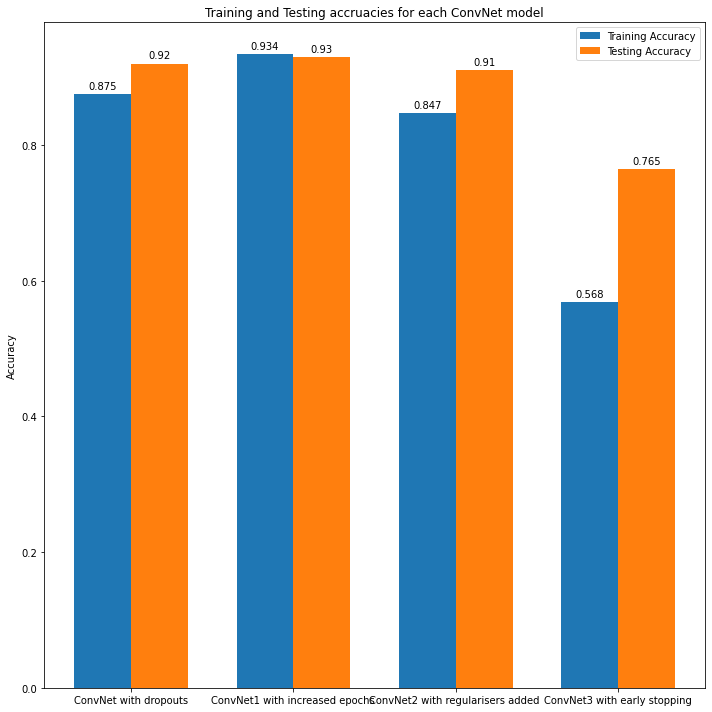

In [79]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['ConvNet with dropouts', 'ConvNet1 with increased epochs', 'ConvNet2 with regularisers added ', 'ConvNet3 with early stopping']
training_accuracy = [round(history.history['accuracy'][-1],3), round(history1.history['accuracy'][-1],3), round(history2.history['accuracy'][-1],3), round(history3.history['accuracy'][-1],3)]
testing_accuracy = [round(score[1],3), round(score1[1],3), round(score2[1],3), round(score3[1],3)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# plt.figure(figsize=[20,20])
fig, ax = plt.subplots(figsize=(10,10))
rects1 = ax.bar(x - width/2, training_accuracy, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, testing_accuracy, width, label='Testing Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Training and Testing accruacies for each ConvNet model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Observation:

From the above plot, we can understand that we have achieved good testing accuracies which neared training accuracies. This implies that the models are not overfitted to the training data. In my opinion, to increase the testing accuracy, we can afford to let the model learn more on training data. But with the existing training data, it may take a lot of epochs and runtime to achieve better results. Instead we can do more data augmentation and provide the model with training data, to achieve good training and testing accuracies.